In [167]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import torchvision.transforms.functional as TF
import random
import matplotlib.pyplot as plt
import os
from torchvision.io import read_image, write_jpeg
from torch.utils.data import Dataset
import torch
import sys
from collections import defaultdict
from tqdm import tqdm


def load_labels(path):
    df = pd.read_csv(path)
    return df


def load_image(path, idx, df):
    img_path = os.path.join(path, df.iloc[idx, 0] + '.jpg')
    image = read_image(img_path)

    return image


def transform_image(image):
    angle = random.randint(-180, 180)
    image = TF.rotate(image, angle)
    
    hflip_prob = random.randint(1, 10)
    if hflip_prob > 5:
        image = TF.hflip(image)
    
    vflip_prob = random.randint(1, 10)
    if vflip_prob > 5:
        image = TF.vflip(image)
    
    noise_prob = random.randint(1,10)
    if noise_prob > 5:
        noise = torch.randint(-15, 15, size=image.size(), dtype=torch.int8)
        # Add the noise to the image
        image = image + noise
        image = image.type(torch.uint8)

    return image


def show_image(image):
    plt.imshow(  image.permute(1, 2, 0)  )
    
    
def append_df(df, labels):
    highest_idx = len(df) - 1
    
    # Sanity Check
    img_number = int(df.iloc[highest_idx]['image_name'].split('_')[1])
    if highest_idx != img_number:
        print(f"[-] We got out of sync at index {highest_idx}")
        print(f"{df.iloc[highest_idx]}")
        sys.exit(-1)
        
    new_idx = highest_idx + 1    
    new_row = {
        "image_name": [f"augment_{new_idx}"],
        "tags": [' '.join(labels)]
    }
    return_row = {
        "image_name": f"augment_{new_idx}",
        "tags": ' '.join(labels)
    }
    
    new_df = pd.concat([df, pd.DataFrame.from_dict(new_row)], ignore_index=True)
    return new_df, return_row


def save_image(base_path, img_name, img):
    path = os.path.join(base_path, img_name)
    write_jpeg(img, path, 100)

    
def get_labels(df, idx):
    labels = df.iloc[idx]['tags']
    return labels.strip().split(' ')


def get_score(labels, dist, max_val):
    label_scores = []
    for label in labels:
        label_scores += [ dist[label] ]

    most_common = max(label_scores)
    rarest = min(label_scores)
    score = (1 - rarest)
    return score, most_common


def get_label_dist(df):
    tags = ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn',
         'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming',
         'selective_logging', 'blow_down']
    
    dist = defaultdict(int)
    for idx in range(len(df)):
        labels = df.iloc[idx]['tags'].strip().split(' ')
        for l in labels:
            dist[l] += 1
    
    for t in tags:
        dist[t] = dist[t] / len(df)
    
    return dist, sum(dist.values())

def get_augmented_label_dist(df):
    tags = ['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn',
         'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming',
         'selective_logging', 'blow_down']
    
    dist = defaultdict(int)
    for idx in range(len(df)):
        if not df.iloc[idx]['image_name'].startswith('augment'):
            continue
        labels = df.iloc[idx]['tags'].strip().split(' ')
        for l in labels:
            dist[l] += 1
    
    for t in tags:
        dist[t] = dist[t] / len(df)
    
    return dist, sum(dist.values())
    
def show_dist(df, title):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_axes([0,0,1,1])
    tags = list(df.keys())
    rate = list(df.values())
    bars = ax.bar(tags, rate, width=0.3)
    ax.set_ylabel('rate',fontsize= 12)
    ax.set_xlabel('tags',fontsize= 12)
    ax.set_xticklabels(tags, rotation=90)
    ax.set_title(title) 
    
    ax.bar_label(bars,[round(r*100, 2) for r in rate])

    plt.show()

    
def augment(df, base_path, new_csv='new_classes.csv'):

    csv_path = os.path.join(base_path, "train_classes.csv")
    img_base_path = os.path.join(base_path, "train-jpg")

    label_dist, max_val = get_label_dist(df)
    len_df = len(df)
    
    counter = 0
    for idx in tqdm(range(10,len_df)):
        trans_tags = df.iloc[idx]['tags'].split(' ')
        score, score_max = get_score(trans_tags, label_dist, max_val)
        if score < 0.9:
            continue

        if df.iloc[idx]['image_name'].startswith('augment'):
            continue

        img = load_image(img_base_path, idx, df)
        for i in range(int(5 * score)):
            trans_img = transform_image(img)[:3,:,:]
            df, new_row = append_df(df, trans_tags)

            save_image(img_base_path, f"{new_row['image_name']}.jpg", trans_img)
            counter += 1

    with open(os.path.join(base_path, new_csv), 'w') as f:
        f.write(df.to_csv(index=False))
    
    print(f"Augmented {counter} images")

    df_new = load_labels(os.path.join(base_path, new_csv))
    label_dist_new, _ = get_label_dist(df_new)

    augmented_label_dist, _ = get_augmented_label_dist(df_new)    
    return df_new, label_dist_new, augmented_label_dist


def normalize_labels(df, label_dist, threshold=500):
    tmp_dist = label_dist.copy()
    new_df = pd.DataFrame(columns=['image_name', 'tags'])
    label_count = defaultdict(int)
    t = tqdm(total=len(label_dist), position=0, leave=True)
    
    while tmp_dist:
        t.update(1)
        rarest_label = min(tmp_dist, key=tmp_dist.get)
        
        if label_count[rarest_label] >= threshold:
            tmp_dist.pop(rarest_label)
            continue
        
        for idx in range(len(df)):
            tags = df.loc[idx, "tags"].split(' ')
            
            if rarest_label in tags:
                new_df = pd.concat([new_df, df.iloc[idx].to_frame().T], ignore_index=True, axis=0)
                
                for local_tag in tags:
                    label_count[local_tag] += 1
            
            if label_count[rarest_label] >= threshold:
                break
        
        tmp_dist.pop(rarest_label)

    t.close()
    return new_df
    

In [168]:
base_path = '/home/gro/Documents/Uni/Erasmus/Vorlesungen/DLVR/Project/datasets/deeplearningproject/'
csv_path = os.path.join(base_path, "train_classes.csv")
delete_csv = os.path.join(base_path, "delete_classes.csv")

df_orig = load_labels(csv_path)
dist_orig, _ = get_label_dist(df_orig)

df_augment, dist_new, dist_augment_only = augment(df_orig, base_path, 'new_classes.csv')
df_delete = normalize_labels(df_augment, dist_augment, 500)

delete_dist, _ = get_label_dist(df_delete)
with open(delete_csv, 'w') as f:
    f.write(df_delete.to_csv(index=False))

100%|████████████████████████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.55it/s]


/tmp/ipykernel_27164/272519754.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tags, rotation=90)


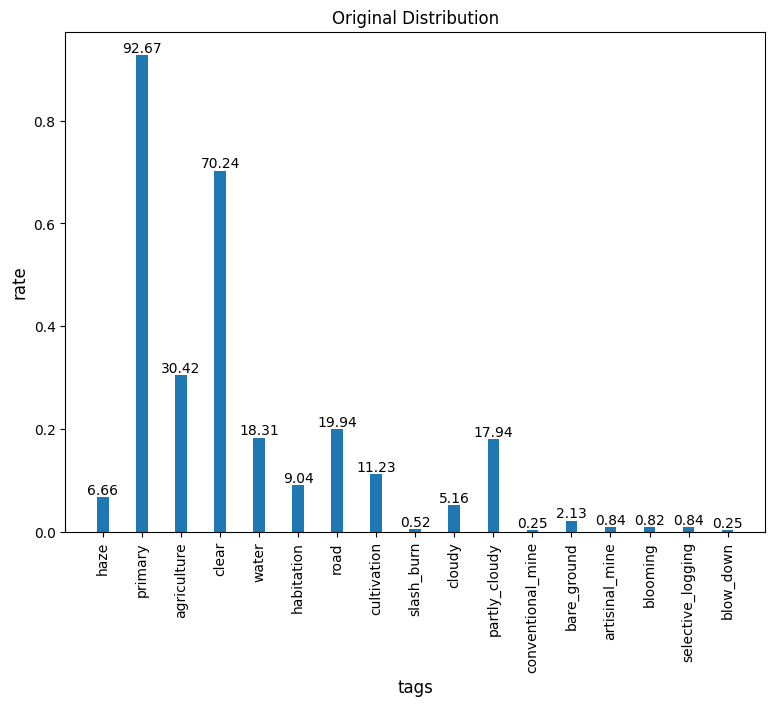

/tmp/ipykernel_27164/272519754.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tags, rotation=90)


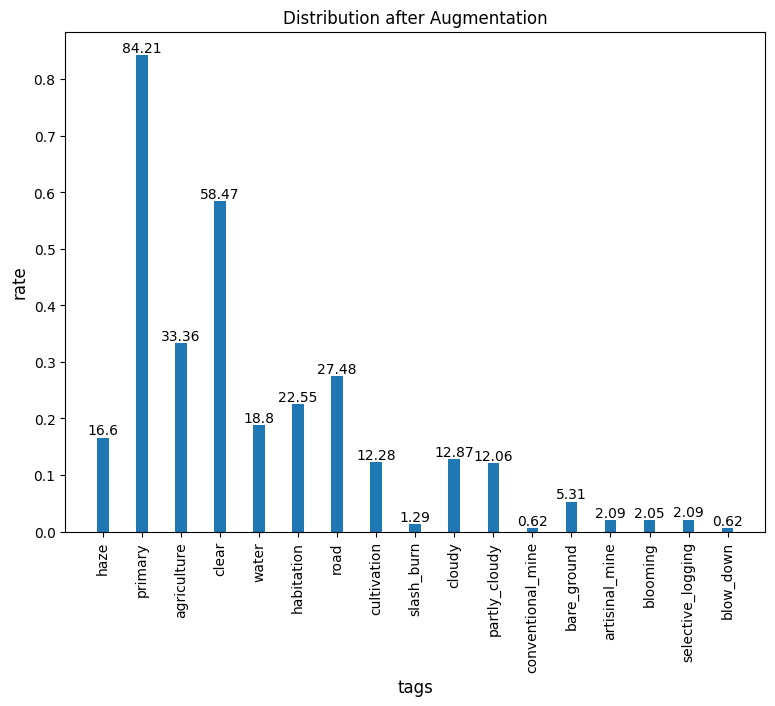

/tmp/ipykernel_27164/272519754.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tags, rotation=90)


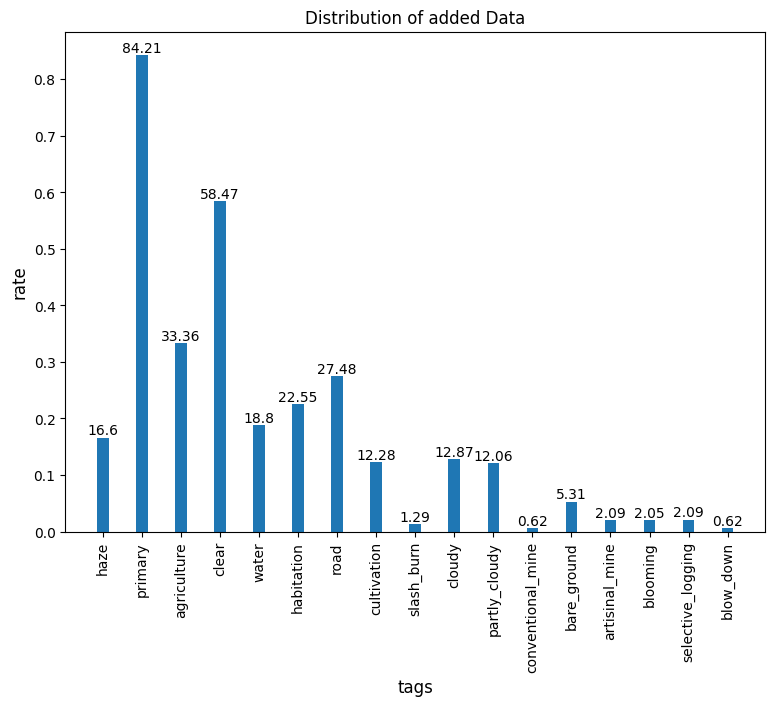

/tmp/ipykernel_27164/272519754.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tags, rotation=90)


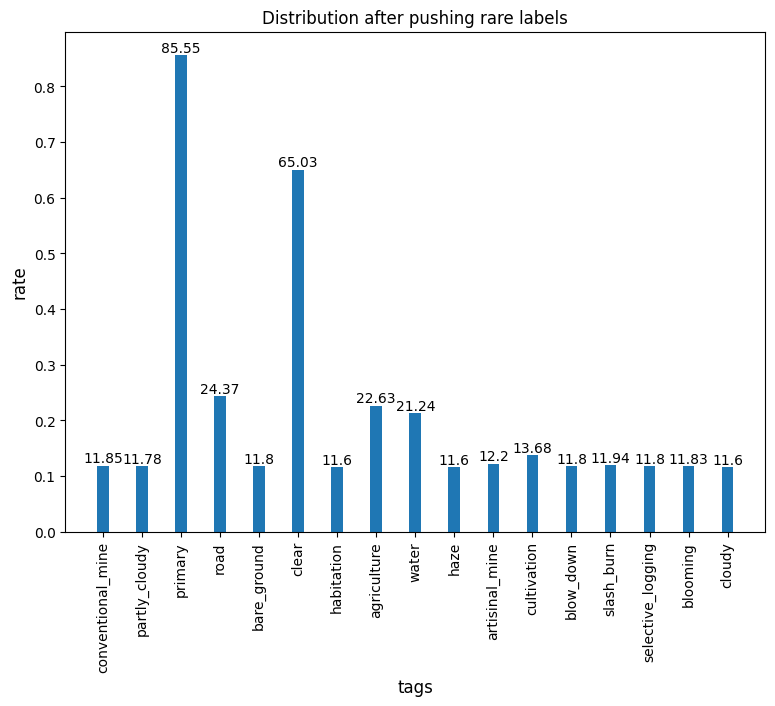

In [169]:
# 'Original Distribution'
show_dist(dist_orig, "Original Distribution")

# "Distribution after Augmentation"
show_dist(dist_new, "Distribution after Augmentation")

# Distribution of added images
show_dist(dist_augment, "Distribution of added Data")

# Distribution after data occlusion
show_dist(delete_dist, "Distribution after pushing rare labels")
